In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')
import pandas as pd
import numpy as np
import core.start
import core.portfolio as portfolio
import config.settings
from time import sleep
from core.utility import *
from core.accountcurve import *
import core.db as db
import config.portfolios
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
p = portfolio.Portfolio(instruments=config.portfolios.p_all)
i = p.instruments
from core.bootstrap import bootstrap
from IPython.display import FileLink, FileLinks

## How to test and integrate new rules

When we create new rules, we want to know three basic things:

* Does it makes money? - **Sharpe ratio**
* How similar is it to existing rules we have in our system? - **Correlation**
* How should we weight the forecasts of those rules in our system? - **Boostrapping**

### Does it make any money?

We test a rule by looking at the Sharpe ratio. Let's take EWMAC and Corn as an example.

In [2]:
i['corn'].forecasts().tail()

,ewmac8,ewmac16,ewmac32,ewmac64,carry_next,brk40,brk80,brk160,brk320
Date,,,,,,,,,
2017-06-19,4.578063,3.633076,1.877577,-0.984837,-6.141447,6.543386,4.184205,8.032910,-6.379380
2017-06-20,2.547694,2.991681,1.720104,-1.003838,-6.354557,3.319368,3.205372,7.750657,-6.394400
2017-06-21,0.794778,2.348492,1.543057,-1.032319,-6.528920,0.318266,2.167041,7.429984,-6.417000
2017-06-22,-1.625324,1.387518,1.234854,-1.109611,-6.935767,-2.936376,0.494541,6.874447,-6.477207
2017-06-23,-4.406252,0.191786,0.817562,-1.229647,-7.516976,-5.599264,-1.171393,6.116379,-6.570911


We can plot the returns for each rule to give us a sense of how it performs. **This is not a scientific approach**, it's just useful to get an idea of what's going on. We'll test this a little better later.

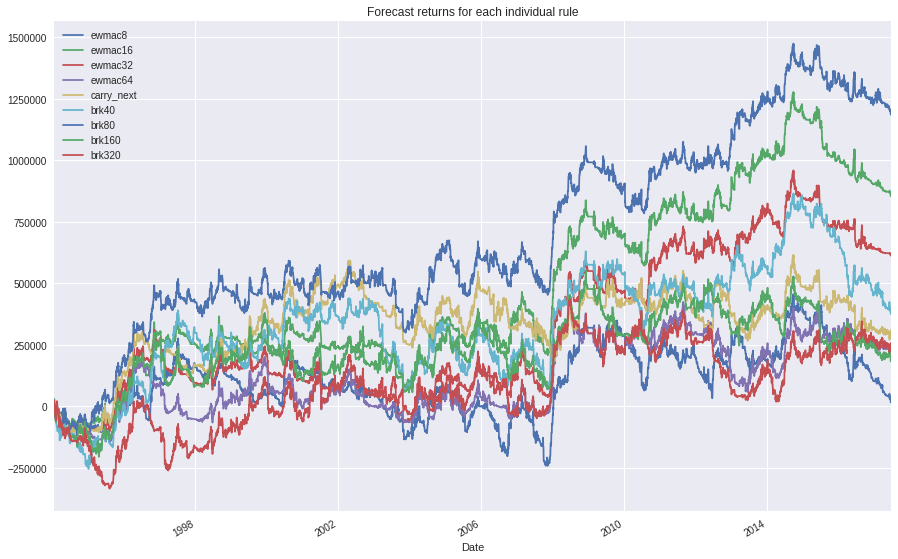

In [3]:
i['corn'].forecast_returns().apply(np.trim_zeros).cumsum().plot(title="Forecast returns for each individual rule")

In general, **faster rules perform better**, if it weren't for costs. There is a balance between the cost of trading and performance.

Equally, slower rules that don't really do any trading at all will underform good active strategies (Law of Active Management).

In this particular case, our original version of the system included faster variations `ewmac2` and `ewmac4`. While these made money when prices moved quickly, the overall costs generated by trading them resulted in losses in the long term. Some instruments are very cheap to trade, and some very expensive to trade, so there's an argument for custom weights depending on instrument, but our system doesn't (yet) support it. Corn is relatively expensive to trade.

### Correlations

The next thing we'd like to check is the correlation of the rules. Most rules fall into one of two categories:
* Trend following- things like EWMAC.
* Mean-reverting - the opposite of trend following- that prices will return to a historical level.

EWMAC, Carry and Breakout are all trend-following type rules; we'd expect them to be fairly correlated. We always seek to have **uncorrelated** sources of return, it means that when one thing isn't making money, something else is.

The daily returns are mostly noise; we'll look at the weekly returns as this gives us a much better picture of correlation.

In [4]:
i['corn'].forecast_returns().apply(np.trim_zeros).resample('W').sum().corr()

,ewmac8,ewmac16,ewmac32,ewmac64,carry_next,brk40,brk80,brk160,brk320
ewmac8,1.000000,0.873318,0.605997,0.346260,0.478647,0.894684,0.734412,0.454133,0.266679
ewmac16,0.873318,1.000000,0.851649,0.539305,0.612794,0.818942,0.899645,0.691801,0.428435
ewmac32,0.605997,0.851649,1.000000,0.814919,0.707664,0.572179,0.812693,0.901167,0.692198
ewmac64,0.346260,0.539305,0.814919,1.000000,0.737491,0.325814,0.530421,0.828681,0.924286
carry_next,0.478647,0.612794,0.707664,0.737491,1.000000,0.476253,0.587280,0.675186,0.702276
brk40,0.894684,0.818942,0.572179,0.325814,0.476253,1.000000,0.774368,0.441746,0.265565
brk80,0.734412,0.899645,0.812693,0.530421,0.587280,0.774368,1.000000,0.717013,0.451406
brk160,0.454133,0.691801,0.901167,0.828681,0.675186,0.441746,0.717013,1.000000,0.756121
brk320,0.266679,0.428435,0.692198,0.924286,0.702276,0.265565,0.451406,0.756121,1.000000


So from the the correlation matrix, we can see `ewmac8` and `ewmac16` are quite correlated (which makes sense, as they cover a similar time period), but everything else not so much. In this case, we might consider dropping the `ewmac8`, but we'd need to do more research first.

### Important Warning

This correlation matrix is from a single instrument, which is not enough data to produce statistical significance at all. This is just a guide. Furthermore, there will be very substantial errors on these correlation numbers, which are also not shown here, and would need to be estimated via bootstrapping.

#### Why not develop a portfolio wide bootstrapping framework for this stuff?

We could, and we probably will, but the reality is, we usually know what the answer before we start- that is; faster rules lose money because of costs, and we are aware of the correlations because we designed the rules ourselves. 

The reality is, designing the system with your brain to begin with can save a lot of work.

## Next Step

Remove any variations (usually the faster ones) that are clearly going to lose money most of the time. There's no point feeding this to an optimizer to give us weights, as these weights have errors, and we already know that the best weight is probably zero.

In [5]:
p_learn = portfolio.Portfolio(instruments=config.portfolios.p_learn)
p_test = portfolio.Portfolio(instruments=config.portfolios.p_test)

In [ ]:
p_learn_results = p_learn.bootstrap_pool()

In [ ]:
p_test_results = p_test.bootstrap_pool()

In [ ]:
p_learn_results.transpose()

,brk160,brk320,brk40,brk80,carry_next,ewmac16,ewmac32,ewmac64,ewmac8
aex,0.117489,0.139642,0.059420,0.151594,0.186761,0.088159,0.074633,0.141656,0.040645
bund,0.072143,0.098958,0.085783,0.104997,0.198562,0.095707,0.086257,0.119182,0.138409
cac,0.073991,0.216791,0.104868,0.071422,0.149355,0.085189,0.082802,0.152757,0.062826
copper,0.142533,0.147899,0.088814,0.091470,0.115095,0.064550,0.084766,0.136743,0.128131
corn,0.116948,0.082226,0.131880,0.114471,0.139032,0.108370,0.095001,0.091934,0.120137
cotton,0.149198,0.151314,0.098671,0.085210,0.128051,0.063580,0.106597,0.108521,0.108858
eur,0.124930,0.142247,0.092811,0.126054,0.152537,0.105790,0.101829,0.097901,0.056029
eurooat,0.039306,0.201330,0.074028,0.077507,0.160194,0.065944,0.058316,0.247065,0.076309
gold,0.091091,0.115867,0.105532,0.136820,0.191977,0.099098,0.089256,0.101196,0.069162
hsi,0.116783,0.126023,0.178296,0.136494,NaN,0.091349,0.128430,0.108913,0.113713


In [ ]:
p_test_results.transpose()

,brk160,brk320,brk40,brk80,carry_next,ewmac16,ewmac32,ewmac64,ewmac8
arabica,0.091411,0.094500,0.102534,0.070266,0.166253,0.115733,0.077644,0.121011,0.160646
aud,0.096275,0.131821,0.114340,0.095504,0.103970,0.079317,0.098211,0.177893,0.102669
bobl,0.135884,0.189463,0.093324,0.095771,NaN,0.110144,0.129083,0.109820,0.136510
cattle,0.102840,0.185989,0.085301,0.113051,0.109736,0.080635,0.108482,0.138746,0.075221
cocoa,0.111439,0.140892,0.113047,0.090367,0.168859,0.068633,0.097852,0.131121,0.077790
crude,0.089997,0.209064,0.092846,0.106617,0.095509,0.062421,0.074637,0.116058,0.152852
dax,0.107493,0.147770,0.126555,0.101628,0.161106,0.063289,0.080811,0.121831,0.089518
eurodollar,0.090753,0.131421,0.108798,0.119241,0.155378,0.078037,0.117951,0.082770,0.115653
eurostoxx,0.100105,0.140422,0.135728,0.099953,0.133559,0.087040,0.128602,0.094811,0.079782
feeder,0.077399,0.131338,0.097178,0.099070,0.192704,0.077128,0.078603,0.137700,0.108880


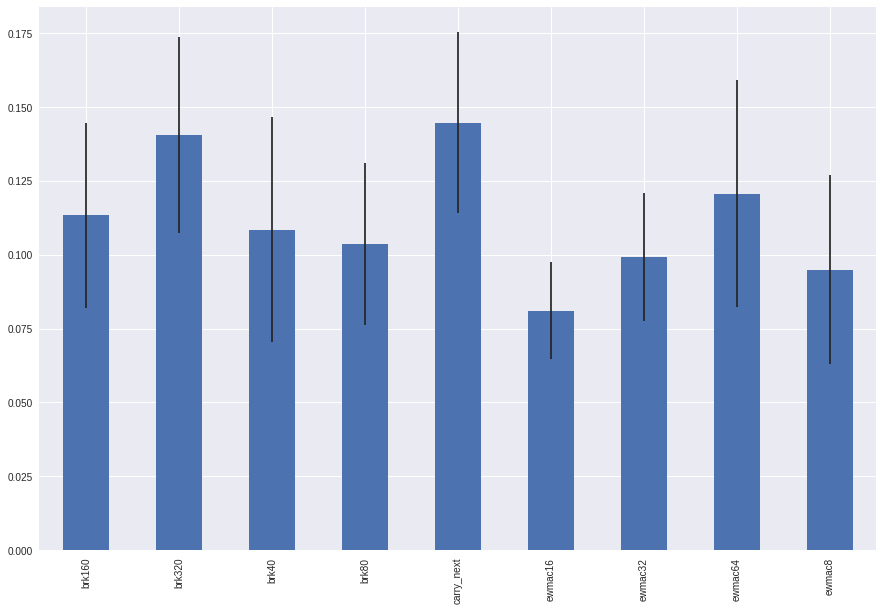

In [19]:
p_learn_results.mean(axis=1).plot.bar(yerr=p_learn_results.std(axis=1))


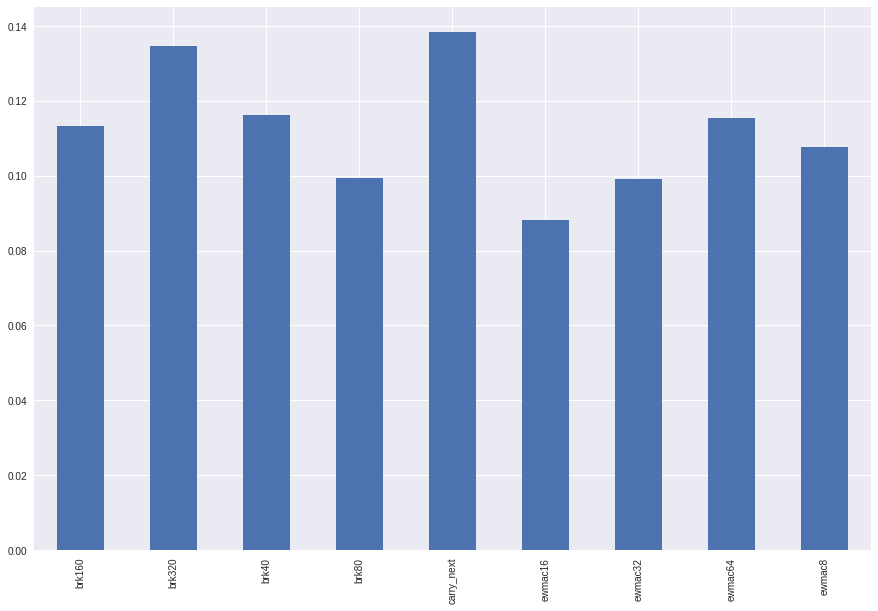

In [ ]:
p_test_results.mean(axis=1).plot.bar()

In [17]:
tabulate.tabulate(p_learn_results.mean(axis=1).to_dict())

TypeError: zip_longest argument #1 must support iteration

In [15]:
import tabulate